<a href="https://colab.research.google.com/github/ctcthrn/ARIMA/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

=== Информация о тренировочных данных ===
Период: 2010-01-01 00:00:00 - 2018-12-31 00:00:00
Всего дней: 3287
Средние продажи: 54664.83
Медианные продажи: 54655.00

=== Информация о тестовых данных ===
Период: 2019-01-01 00:00:00 - 2019-12-31 00:00:00
Всего дней: 365


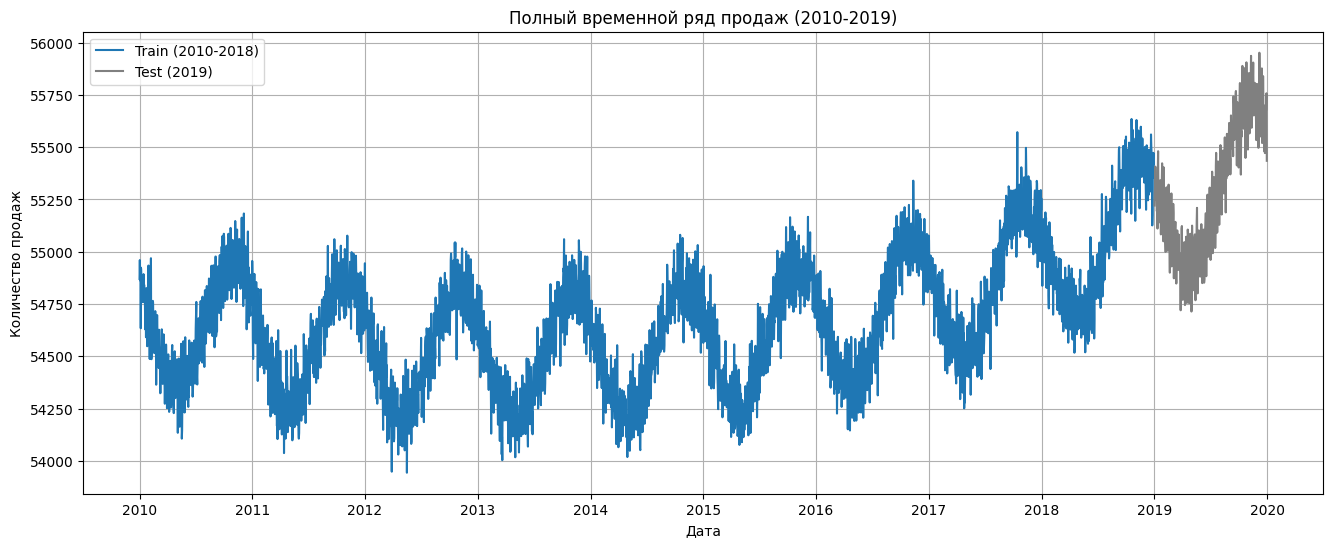

In [52]:
# Загрузка и предварительный анализ данных
train = pd.read_csv('train.csv', parse_dates=['Date'])
test = pd.read_csv('test.csv', parse_dates=['Date'])

# Агрегация данных по дням (сумма продаж по всем магазинам и товарам)
train_ts = train.set_index('Date')['number_sold'].resample('D').sum()
test_ts = test.set_index('Date')['number_sold'].resample('D').sum()

# Вывод основной информации о данных
print("=== Информация о тренировочных данных ===")
print(f"Период: {train_ts.index.min()} - {train_ts.index.max()}")
print(f"Всего дней: {len(train_ts)}")
print(f"Средние продажи: {train_ts.mean():.2f}")
print(f"Медианные продажи: {train_ts.median():.2f}")
print("\n=== Информация о тестовых данных ===")
print(f"Период: {test_ts.index.min()} - {test_ts.index.max()}")
print(f"Всего дней: {len(test_ts)}")

# Визуализация полного временного ряда
plt.figure(figsize=(16, 6))
plt.plot(train_ts, label='Train (2010-2018)')
plt.plot(test_ts, label='Test (2019)', color='gray')
plt.title('Полный временной ряд продаж (2010-2019)')
plt.xlabel('Дата')
plt.ylabel('Количество продаж')
plt.legend()
plt.grid(True)
plt.show()

Визуально наблюдается рост продаж с 2010 по 2019 год. Пики продаж приходятся на конец года (новогодний сезон). Видно годовую сезонность (синусообразный вид графика).

<Figure size 1200x800 with 0 Axes>

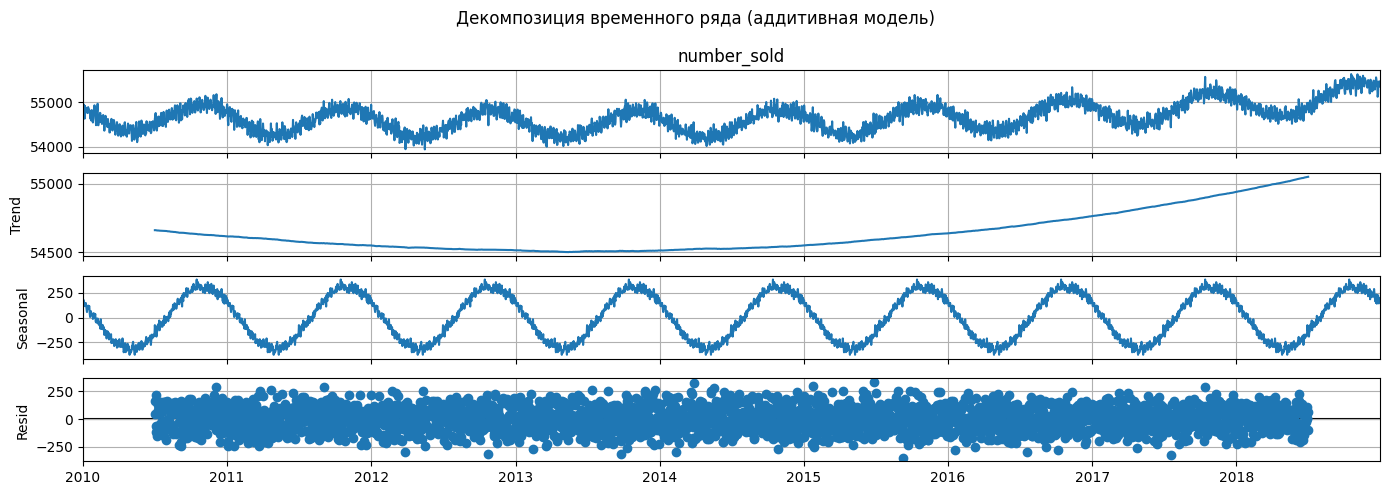

In [53]:
# Декомпозиция временного ряда
try:
    decomposition = seasonal_decompose(train_ts, model='additive', period=365)
except:
    temp_period = min(365, len(train_ts)//2)
    decomposition = seasonal_decompose(train_ts, model='additive', period=temp_period)

plt.figure(figsize=(12, 8))
decomposition.plot()
plt.suptitle('Декомпозиция временного ряда (аддитивная модель)')
plt.tight_layout()
plt.show()

До 2014 года продажи немного уменьшались, а затем наблюдается восходящий тренд. Ярковыраженная годовая сезонность. Остатки распределены +- равномерно.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3287
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -19683.854
Date:                Sun, 11 May 2025   AIC                          39377.708
Time:                        17:11:48   BIC                          39408.196
Sample:                    01-01-2010   HQIC                         39388.624
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9261      0.030     31.341      0.000       0.868       0.984
ar.L2         -0.4751      0.016    -30.023      0.000      -0.506      -0.444
ma.L1         -1.5919      0.031    -50.584      0.0

<Figure size 1400x600 with 0 Axes>

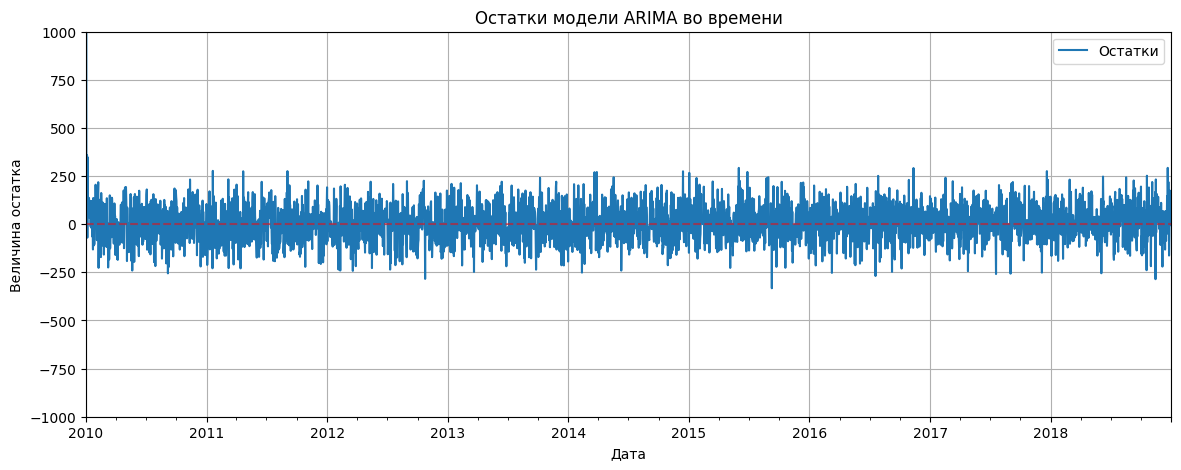

<Figure size 1400x600 with 0 Axes>

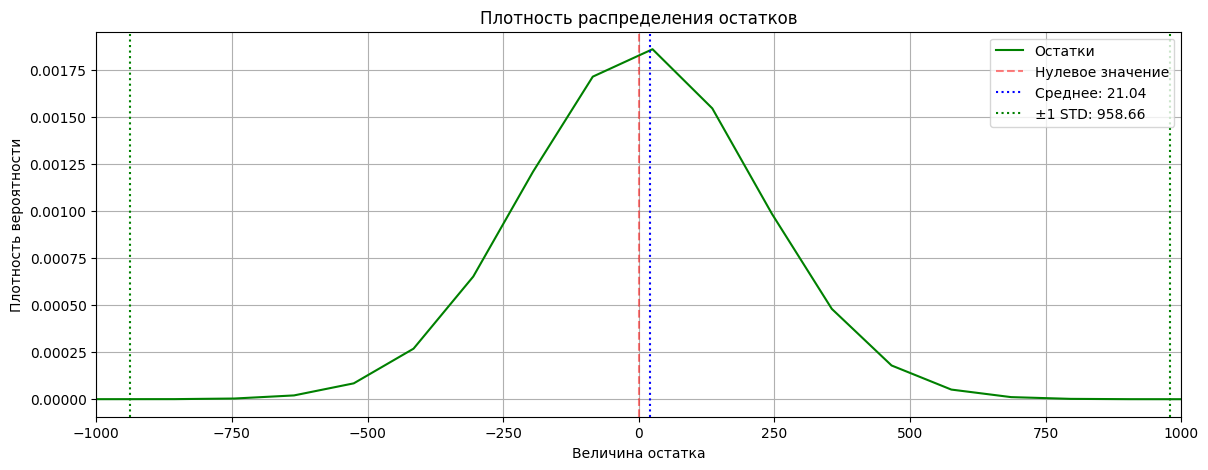

Среднее остатков: 21.04
Стандартное отклонение: 958.66
Минимальное значение: -332.62
Максимальное значение: 54686.54


In [54]:
# Построение и анализ ARIMA модели
deseasonalized = train_ts - decomposition.seasonal

# Подбор параметров ARIMA
model = ARIMA(deseasonalized, order=(2,1,2))
arima_model = model.fit()
print(arima_model.summary())

# Анализ остатков модели
residuals = pd.DataFrame(arima_model.resid, columns=['Остатки'])

# График остатков во времени
plt.figure(figsize=(14, 6))
residuals.plot(ylim=(-1000, 1000), title='Остатки модели ARIMA во времени')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.ylabel('Величина остатка')
plt.xlabel('Дата')
plt.grid(True)
plt.show()

# График распределения остатков
plt.figure(figsize=(14, 6))
residuals.plot(kind='kde', title='Плотность распределения остатков', color='green')
plt.xlim(-1000, 1000)
plt.xlabel('Величина остатка')
plt.ylabel('Плотность вероятности')
plt.grid(True)

plt.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='Нулевое значение')
mean_val = residuals.mean().values[0]
plt.axvline(x=mean_val, color='b', linestyle=':', label=f'Среднее: {mean_val:.2f}')
std_val = residuals.std().values[0]
plt.axvline(x=mean_val+std_val, color='g', linestyle=':', label=f'±1 STD: {std_val:.2f}')
plt.axvline(x=mean_val-std_val, color='g', linestyle=':')
plt.legend()
plt.show()

print(f"Среднее остатков: {residuals.mean().values[0]:.2f}")
print(f"Стандартное отклонение: {residuals.std().values[0]:.2f}")
print(f"Минимальное значение: {residuals.min().values[0]:.2f}")
print(f"Максимальное значение: {residuals.max().values[0]:.2f}")

Ошибки в среднем близки к нулю (среднее остатков = 21.04). Основная масса ошибок колеблется в пределах +-1000 (стандартное отклонение 958.66). Но есть и редкие крупные выбросы (максимальная ошибка 54686.54 почти равна средним продажам 54664.83). Ошибки в основном нормально распределены (JB тест p-value=0.25)

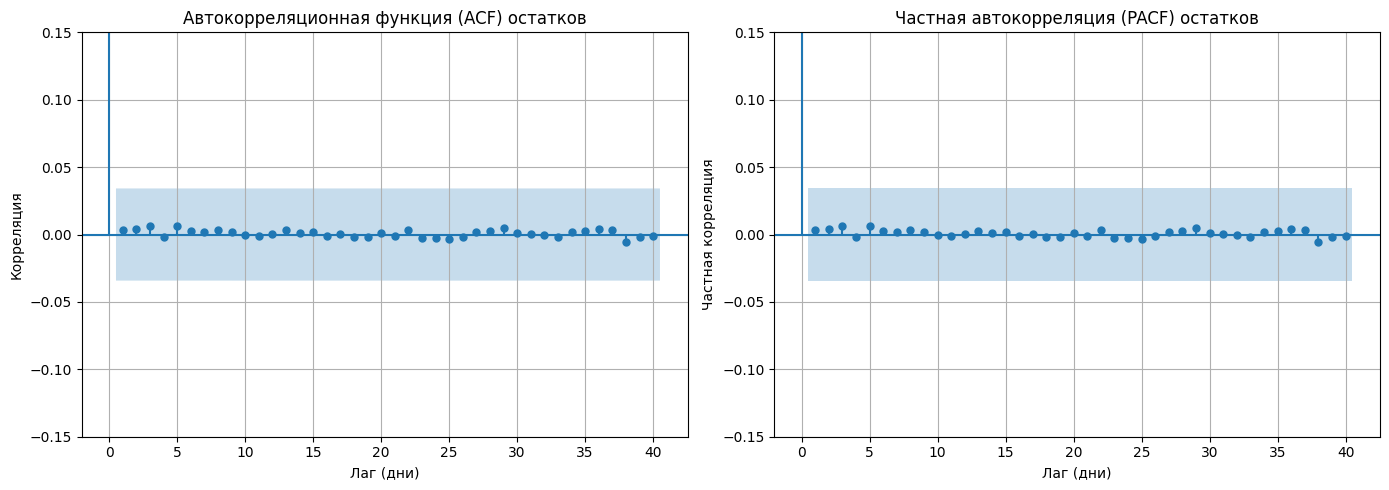

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['axes.grid'] = True

fig, (ax1, ax2) = plt.subplots(1, 2)

# График ACF
plot_acf(residuals,
         lags=40,
         alpha=0.05,
         title='Автокорреляционная функция (ACF) остатков',
         ax=ax1)
ax1.set_ylim(-0.15, 0.15)
ax1.set_xlabel('Лаг (дни)')
ax1.set_ylabel('Корреляция')

# График PACF
plot_pacf(residuals,
          lags=40,
          alpha=0.05,
          title='Частная автокорреляция (PACF) остатков',
          ax=ax2)
ax2.set_ylim(-0.15, 0.15)
ax2.set_xlabel('Лаг (дни)')
ax2.set_ylabel('Частная корреляция')

# Настройка общего вида
plt.tight_layout()
plt.show()


=== Прогнозирование на тестовый период ===


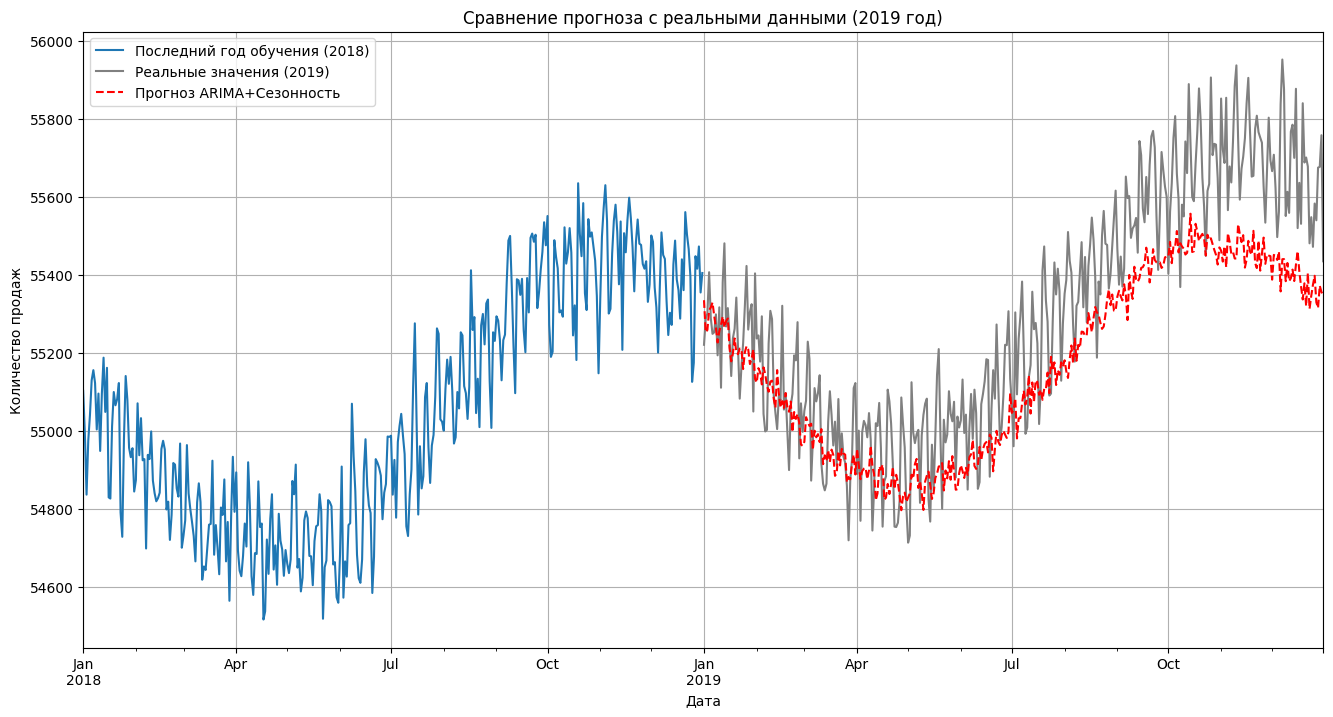


=== Метрики качества прогноза ===
MAPE: 0.28% (средняя абсолютная процентная ошибка)
RMSE: 191.54 (среднеквадратичная ошибка)
R2: 0.61 (коэффициент детерминации)


In [56]:
# Прогнозирование и оценка качества
print("\n=== Прогнозирование на тестовый период ===")
forecast_steps = len(test_ts)
forecast = arima_model.forecast(steps=forecast_steps)

# Восстановление сезонной компоненты
seasonal_pattern = decomposition.seasonal[-365:].values
repeats = int(np.ceil(forecast_steps/365))
seasonal_component = np.tile(seasonal_pattern, repeats)[:forecast_steps]

forecast = pd.Series(forecast.values + seasonal_component, index=test_ts.index)

# Визуализация прогноза
min_len = min(len(test_ts), len(forecast))
test_ts_aligned = test_ts.iloc[:min_len]
forecast_aligned = forecast.iloc[:min_len]

plt.figure(figsize=(16, 8))
train_ts[-365:].plot(label='Последний год обучения (2018)')
test_ts_aligned.plot(label='Реальные значения (2019)', color='gray')
forecast_aligned.plot(label='Прогноз ARIMA+Сезонность', style='--', color='red')
plt.title('Сравнение прогноза с реальными данными (2019 год)')
plt.xlabel('Дата')
plt.ylabel('Количество продаж')
plt.legend()
plt.grid(True)
plt.show()

# Расчет метрик качества
metrics = {
    'MAPE': mean_absolute_percentage_error(test_ts_aligned, forecast_aligned) * 100,
    'RMSE': sqrt(mean_squared_error(test_ts_aligned, forecast_aligned)),
    'R2': r2_score(test_ts_aligned, forecast_aligned)
}

print("\n=== Метрики качества прогноза ===")
print(f"MAPE: {metrics['MAPE']:.2f}% (средняя абсолютная процентная ошибка)")
print(f"RMSE: {metrics['RMSE']:.2f} (среднеквадратичная ошибка)")
print(f"R2: {metrics['R2']:.2f} (коэффициент детерминации)")

# Сохранение результатов
forecast.to_csv('arima_seasonal_forecast.csv', header=['number_sold'])

Модель объясняет 61% изменчивости данных. Достаточно высокая точность MAPE: 0.28% и маленькая ошибка отонительно среднего значения RMSE: 191.54.